In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import os

def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))  # Resize to 224x224
    image = image / 255.0  # Normalize pixel values
    return image

image_folder = '/content/drive/MyDrive/Myntra_images'
preprocessed_images = []
for img_file in os.listdir(image_folder):
    img_path = os.path.join(image_folder, img_file)
    preprocessed_images.append(preprocess_image(img_path))


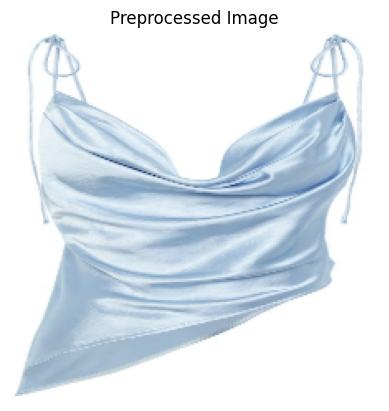

In [ ]:
import matplotlib.pyplot as plt

if preprocessed_images:
    plt.imshow(preprocessed_images[0])
    plt.title('Preprocessed Image')
    plt.axis('off')  # Hide axis
    plt.show()
else:
    print("No images found in the folder.")

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

def extract_features(img):
    base_model = VGG16(weights='imagenet', include_top=False)
    model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    features = model.predict(img)
    return features.flatten()  # Flatten to make it suitable for clustering

features_list = [extract_features(img) for img in preprocessed_images]

1/1 [==============================] - 1s 656ms/step


1/1 [==============================] - 1s 640ms/step


1/1 [==============================] - 1s 657ms/step


In [ ]:
if features_list:
    print("Features of the first image:")
    print(features_list[0])
else:
    print("No features extracted.")

Features of the first image:
[0. 0. 0. ... 0. 0. 0.]


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Generate synthetic timestamps
num_images = len(preprocessed_images)
start_date = datetime(2022, 1, 1)
end_date = datetime(2023, 1, 1)
timestamps = [start_date + timedelta(days=x) for x in np.linspace(0, (end_date - start_date).days, num_images)]

# Create metadata with synthetic timestamps
metadata = [{'filename': f'image_{i}.jpg', 'timestamp': timestamps[i]} for i in range(num_images)]
metadata_df = pd.DataFrame(metadata)

# Combine with extracted features
features_df = pd.DataFrame(features_list)
combined_df = pd.concat([metadata_df, features_df], axis=1)

# Convert timestamp to datetime and set as index
combined_df['timestamp'] = pd.to_datetime(combined_df['timestamp'])
combined_df.set_index('timestamp', inplace=True)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


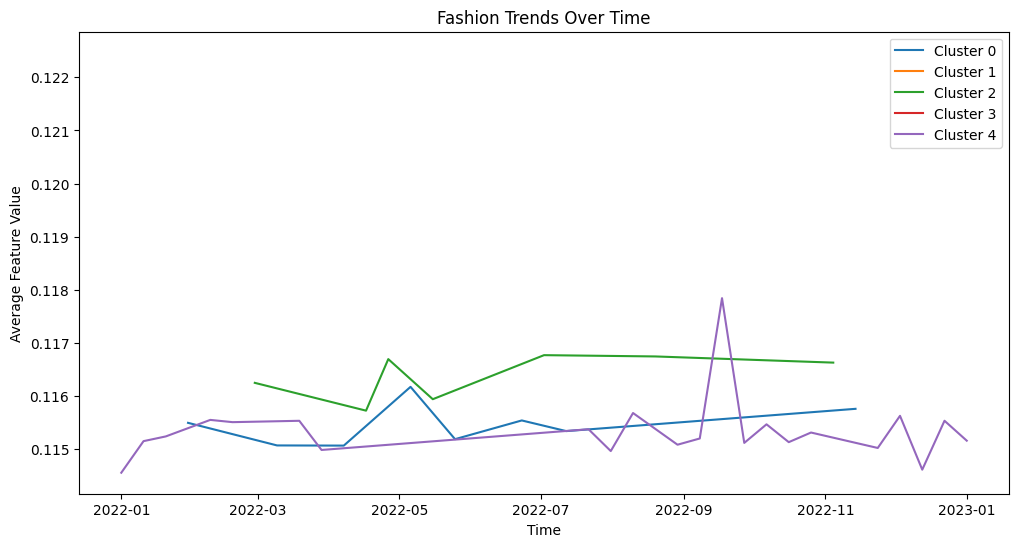

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Number of clusters
num_clusters = 5

# Apply KMeans clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
combined_df['cluster'] = kmeans.fit_predict(combined_df.drop(columns=['filename']))

# Plot clusters over time
plt.figure(figsize=(12, 6))
for cluster in range(num_clusters):
    cluster_data = combined_df[combined_df['cluster'] == cluster]
    plt.plot(cluster_data.index, cluster_data.drop(columns=['filename', 'cluster']).mean(axis=1), label=f'Cluster {cluster}')
plt.legend()
plt.title('Fashion Trends Over Time')
plt.xlabel('Time')
plt.ylabel('Average Feature Value')
plt.show()


In [ ]:
from sklearn.cluster import KMeans

# Assuming 'features' is a numpy array of your extracted features
kmeans = KMeans(n_clusters=5, random_state=0).fit(features_list)
labels = kmeans.labels_




/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
import pandas as pd

# Create a DataFrame for features and labels
df = pd.DataFrame(features_list)
df['label'] = labels

# Calculate centroids
centroids = df.groupby('label').mean()
print(centroids)

# Calculate other statistics like median, std, etc.
stats = df.groupby('label').agg(['mean', 'median', 'std'])
print(stats)


       0      1      2      3      4      5      6      7      8      9      \
label                                                                         
0        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

       ...     25078  25079  25080  25081  25082  25083  25084  25085  25086  \
label  ...                                                                     
0      ...  7.556977    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1      ...  7.600920    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2      ...  7.572054    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3      ...  7.482564    0.0    0.0    0.0    0

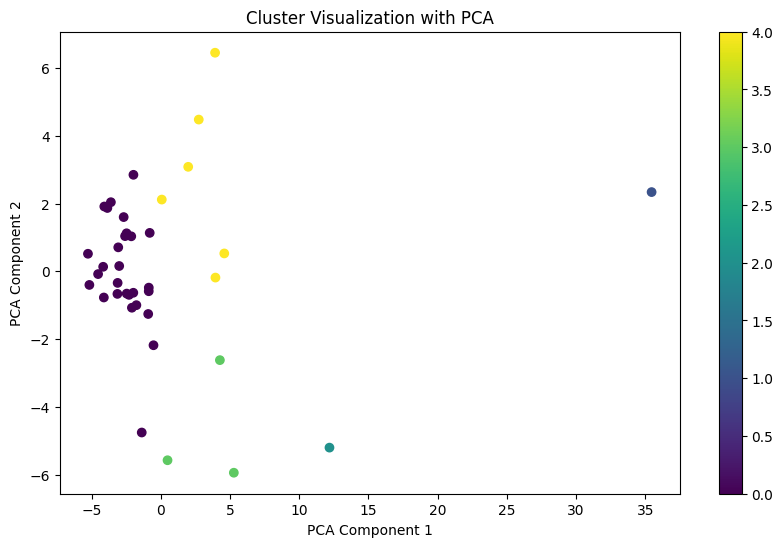

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 2D
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features_list)

# Plot clusters
plt.figure(figsize=(10, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap='viridis')
plt.colorbar()
plt.title('Cluster Visualization with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import os

# Load the VGG16 model pre-trained on ImageNet
model = VGG16(weights='imagenet')

# Function to predict and decode labels
def predict_labels(image_path):
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)

    preds = model.predict(image)
    labels = decode_predictions(preds, top=3)[0]
    return [(label[1], label[2]) for label in labels]

# Folder containing images
folder_path = '/content/drive/MyDrive/Myntra_images'
image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Dictionary to store results
results = {}

# Loop through all images in the folder
for image_file in image_files:
    image_path = os.path.join(folder_path, image_file)
    labels = predict_labels(image_path)
    results[image_file] = labels
    print(f"Predicted labels for {image_file}: {labels}")




1/1 [==============================] - 1s 694ms/step
Predicted labels for Copy of c1.png: [('mailbag', 0.14621699), ('gown', 0.106384866), ('brassiere', 0.07707475)]
1/1 [==============================] - 1s 577ms/step
Predicted labels for Copy of c2.png: [('trench_coat', 0.35314396), ('wool', 0.16155578), ('stole', 0.1411475)]
1/1 [==============================] - 1s 570ms/step
Predicted labels for Copy of c5.png: [('overskirt', 0.3659374), ('gown', 0.20909308), ('cloak', 0.13046245)]
1/1 [==============================] - 1s 573ms/step
Predicted labels for Copy of c10.png: [('stole', 0.23872447), ('chain_mail', 0.2050941), ('velvet', 0.15588503)]
1/1 [==============================] - 1s 581ms/step
Predicted labels for Copy of c3.png: [('hoopskirt', 0.51444304), ('overskirt', 0.3895252), ('gown', 0.08910698)]
1/1 [==============================] - 1s 564ms/step
Predicted labels for Copy of c6.png: [('trench_coat', 0.9119571), ('kimono', 0.022393176), ('velvet', 0.017769873)]
1/1 [==